<a href="https://colab.research.google.com/github/m-bashari-m/vehicle-color-recognition/blob/main/src/rgb_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Prepare utils file

!wget https://raw.githubusercontent.com/m-bashari-m/vehicle-color-recognition/main/src/utils.py

--2022-06-03 17:31:23--  https://raw.githubusercontent.com/m-bashari-m/vehicle-color-recognition/main/src/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9588 (9.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   9.36K  --.-KB/s    in 0s      

2022-06-03 17:31:23 (105 MB/s) - ‘utils.py’ saved [9588/9588]



In [2]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [3]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from utils import ModelCreator, get_train_val_ds, ErrorAnalyzer, get_class_weight

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE
N_CLASSES = 16
HUB_URL = 'https://tfhub.dev/google/bit/m-r50x1/1'

In [5]:
dataset_dir = os.path.join('drive', 'MyDrive', 'cars')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

In [6]:
# Get shuffled train and validation dataset with one-hot labels

train_ds, val_ds = get_train_val_ds(train_dir, val_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

Found 17043 files belonging to 16 classes.
Found 3495 files belonging to 16 classes.


In [7]:
# Get class weights which have calculated from the previous notebook and stored in github

classes, class_weight = get_class_weight()

In [ ]:
for color, weight in zip(classes, class_weight.values()):
  print(color, "    \t=>", weight)

beige     	=> 17.94
black     	=> 13.8
blue     	=> 15.47
brown     	=> 17.92
cream     	=> 56.81
crimson     	=> 76.43
gold     	=> 56.81
green     	=> 21.2
grey     	=> 12.41
navy-blue     	=> 58.77
orange     	=> 22.37
red     	=> 16.39
silver     	=> 20.17
titanium     	=> 56.81
white     	=> 2.97
yellow     	=> 20.68


In [8]:
train_ds = (
    train_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=AUTOTUNE).
    prefetch(AUTOTUNE))

val_ds = (
    val_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=AUTOTUNE).
    prefetch(AUTOTUNE))

In [9]:
rgb_creator = ModelCreator(HUB_URL, 'RGB-model')
rgb_model = rgb_creator.make_model(img_size=IMG_SIZE)

Model: "RGB-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 dense (Dense)               (None, 600)               1229400   
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                9616      
                                                                 
Total params: 24,739,368
Trainable params: 1,239,016
Non-trainable params: 23,500,352
_________________________________________________________________


In [10]:
# Callbacks are EarlyStopping and ModelCheckpoint

callbacks = rgb_creator.get_callbacks()

## ***First*** day of training

In [11]:
history = rgb_model.fit(train_ds,
                        callbacks=callbacks,
                        epochs=15,
                        class_weight=class_weight)

Epoch 1/15
533/533 [==============================] - 2107s 4s/step - loss: 1240.4811 - auc: 0.3695 - accuracy: 0.5495
Epoch 2/15
533/533 [==============================] - 151s 281ms/step - loss: 1182.8999 - auc: 0.5072 - accuracy: 0.6729
Epoch 3/15
533/533 [==============================] - 150s 280ms/step - loss: 865.5900 - auc: 0.5664 - accuracy: 0.7188
Epoch 4/15
533/533 [==============================] - 150s 280ms/step - loss: 633.8220 - auc: 0.6083 - accuracy: 0.7492
Epoch 5/15
533/533 [==============================] - 150s 280ms/step - loss: 466.5838 - auc: 0.6344 - accuracy: 0.7680
Epoch 6/15
533/533 [==============================] - 151s 281ms/step - loss: 371.2820 - auc: 0.6597 - accuracy: 0.7833
Epoch 7/15
533/533 [==============================] - 151s 280ms/step - loss: 257.0945 - auc: 0.6939 - accuracy: 0.8050
Epoch 8/15
533/533 [==============================] - 150s 280ms/step - loss: 186.1813 - auc: 0.7291 - accuracy: 0.8286
Epoch 9/15
533/533 [====================

In [12]:
rgb_model.save('./drive/MyDrive/checkpoints/rgb-model-15.h5')

In [13]:
analyzer = ErrorAnalyzer(model=rgb_model,
                         model_name='RGB-model-1',
                         ds=val_ds,
                         classes=classes)

Making confusion matrix:


  0%|          | 0/55 [00:00<?, ?it/s]

Saving confusion matrix


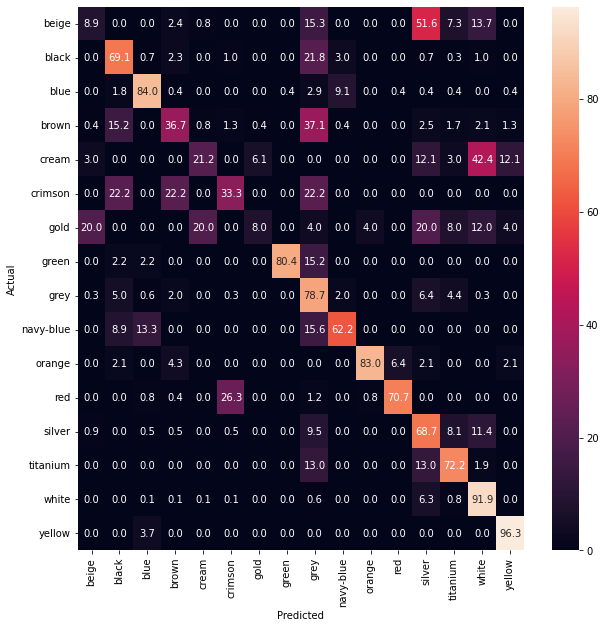

In [14]:
analyzer.plot_confusion_mat()

In [15]:
analyzer.evaluate_model()

Calculating error types...
Writing in log file...
 All done. Check log file => RGB-model-1.csv


In [16]:
history = rgb_model.fit(train_ds,
                        callbacks=callbacks,
                        epochs=25,
                        initial_epoch=15,
                        class_weight=class_weight)

Epoch 16/25
533/533 [==============================] - 151s 281ms/step - loss: 39.2574 - auc: 0.8381 - accuracy: 0.8857
Epoch 17/25
533/533 [==============================] - 150s 280ms/step - loss: 33.9198 - auc: 0.8501 - accuracy: 0.8902
Epoch 18/25
533/533 [==============================] - 151s 281ms/step - loss: 28.4424 - auc: 0.8596 - accuracy: 0.8960
Epoch 19/25
533/533 [==============================] - 150s 280ms/step - loss: 24.2731 - auc: 0.8698 - accuracy: 0.9004
Epoch 20/25
533/533 [==============================] - 150s 280ms/step - loss: 21.8002 - auc: 0.8768 - accuracy: 0.9044
Epoch 21/25
533/533 [==============================] - 151s 281ms/step - loss: 19.3043 - auc: 0.8877 - accuracy: 0.9081
Epoch 22/25
533/533 [==============================] - 150s 280ms/step - loss: 17.8724 - auc: 0.8884 - accuracy: 0.9111
Epoch 23/25
533/533 [==============================] - 150s 280ms/step - loss: 16.0079 - auc: 0.8918 - accuracy: 0.9093
Epoch 24/25
533/533 [===================

In [17]:
rgb_model.save('./drive/MyDrive/checkpoints/rgb-model-25.h5')

Making confusion matrix:


  0%|          | 0/55 [00:00<?, ?it/s]

Saving confusion matrix


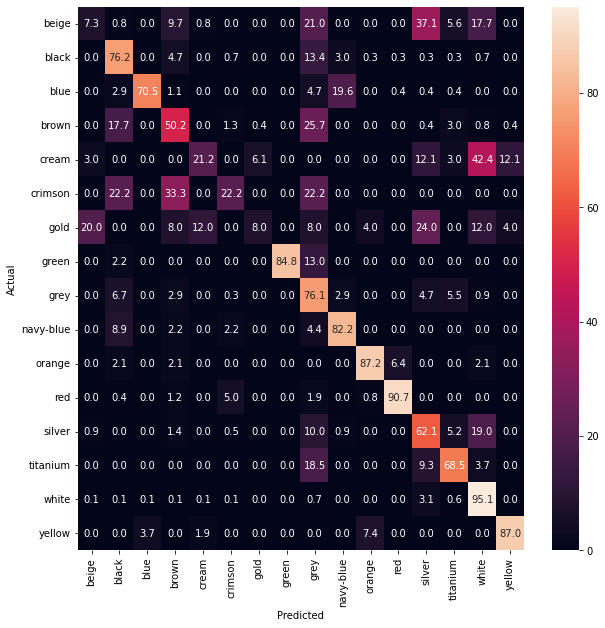

Calculating error types...
Writing in log file...
 All done. Check log file => RGB-model-1.csv


In [18]:
analyzer = ErrorAnalyzer(model=rgb_model,
                         model_name='RGB-model-2',
                         ds=val_ds,
                         classes=classes)

analyzer.plot_confusion_mat()
analyzer.evaluate_model()

In [20]:
history = rgb_model.fit(train_ds,
                        callbacks=callbacks,
                        epochs=35,
                        initial_epoch=25,
                        class_weight=class_weight)

Epoch 26/35
533/533 [==============================] - 151s 282ms/step - loss: 13.4865 - auc: 0.9078 - accuracy: 0.9149
Epoch 27/35
533/533 [==============================] - 151s 281ms/step - loss: 12.7034 - auc: 0.9086 - accuracy: 0.9174
Epoch 28/35
533/533 [==============================] - 151s 281ms/step - loss: 11.6468 - auc: 0.9109 - accuracy: 0.9189
Epoch 29/35
533/533 [==============================] - 151s 281ms/step - loss: 10.8505 - auc: 0.9190 - accuracy: 0.9242
Epoch 30/35
533/533 [==============================] - 150s 280ms/step - loss: 11.3177 - auc: 0.9134 - accuracy: 0.9194
Epoch 31/35
533/533 [==============================] - 151s 280ms/step - loss: 10.6002 - auc: 0.9165 - accuracy: 0.9206
Epoch 32/35
533/533 [==============================] - 151s 280ms/step - loss: 10.4589 - auc: 0.9201 - accuracy: 0.9229
Epoch 33/35
533/533 [==============================] - 151s 281ms/step - loss: 10.1019 - auc: 0.9231 - accuracy: 0.9258
Epoch 34/35
533/533 [===================

In [21]:
rgb_model.save('./drive/MyDrive/checkpoints/rgb-model-35.h5')

Making confusion matrix:


  0%|          | 0/55 [00:00<?, ?it/s]

Saving confusion matrix


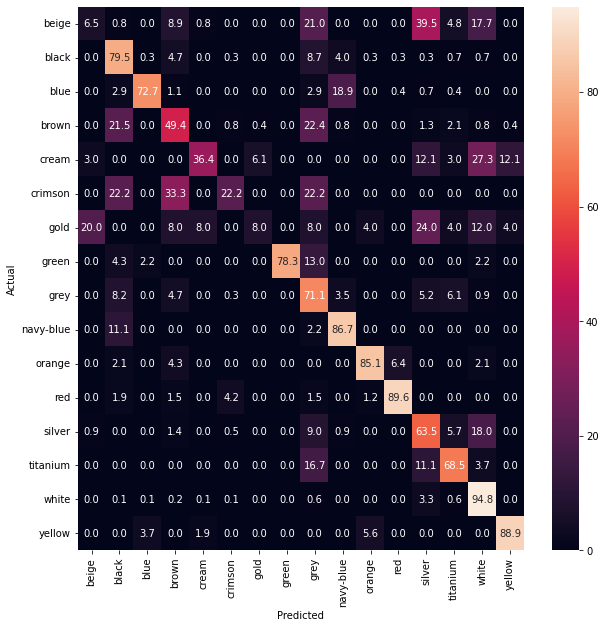

Calculating error types...
Writing in log file...
 All done. Check log file => RGB-model-3.csv


In [22]:
analyzer = ErrorAnalyzer(model=rgb_model,
                         model_name='RGB-model-3',
                         ds=val_ds,
                         classes=classes)

analyzer.plot_confusion_mat()
analyzer.evaluate_model()

## ***Second*** day  

In [ ]:
rgb_model = tf.keras.models.load_model('./drive/MyDrive/checkpoints/rgb-model-15.h5',
                                        custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
rgb_model.save('./drive/MyDrive/checkpoints/rgb-model-15.h5')

In [ ]:
analyzer = ErrorAnalyzer(model=rgb_model, model_name='RGB-model-2', ds=val_ds, classes=classes)

Making confusion matrix:


  0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
analyzer.plot_confusion_mat()

In [ ]:
analyzer.evaluate_model()